In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples=100

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for sbl results
z_sbl = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # sbl results
gamma_sbl = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # sbl gamma values
hit_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # Hit rate for sbl
support_recovery_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # Miss detection rate for sbl
false_alarm_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # False alarm rate for sbl
norm_mse_sbl = np.zeros((num_samples, len(snr_db_array)))  # Norm MSE for sbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply sbl algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_sbl[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, snr_db_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for sbl
        hit_rate_sbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for sbl
        support_recovery_rate_sbl[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for sbl
        false_alarm_rate_sbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for sbl
        norm_mse_sbl[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.50s/it]

Converged after 489 iterations



Processing Samples:   1%|          | 1/100 [01:30<2:28:44, 90.15s/it]

Converged after 301 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.63s/it]

Converged after 481 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.45s/it]

Converged after 477 iterations



Processing Samples:   2%|▏         | 2/100 [02:54<2:21:27, 86.61s/it]

Converged after 357 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.81s/it]

Converged after 472 iterations



Processing Samples:   3%|▎         | 3/100 [04:23<2:21:54, 87.78s/it]

Converged after 452 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.21s/it]

Converged after 330 iterations



Processing Samples:   4%|▍         | 4/100 [05:46<2:17:13, 85.76s/it]

Converged after 434 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.85s/it]

Converged after 440 iterations



Processing Samples:   5%|▌         | 5/100 [07:08<2:13:58, 84.61s/it]

Converged after 434 iterations



Processing Samples:   6%|▌         | 6/100 [08:36<2:14:02, 85.56s/it]

Converged after 367 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.79s/it]

Converged after 400 iterations



Processing Samples:   7%|▋         | 7/100 [09:58<2:10:49, 84.40s/it]

Converged after 326 iterations



Processing Samples:   8%|▊         | 8/100 [11:24<2:10:08, 84.88s/it]

Converged after 409 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.97s/it]

Converged after 405 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.54s/it]

Converged after 464 iterations



Processing Samples:  10%|█         | 10/100 [14:16<2:08:09, 85.44s/it]

Converged after 402 iterations



Processing Samples:  11%|█         | 11/100 [15:43<2:07:39, 86.07s/it]

Converged after 366 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.81s/it]

Converged after 492 iterations



Processing Samples:  12%|█▏        | 12/100 [17:06<2:05:02, 85.26s/it]

Converged after 337 iterations



Processing Samples:  13%|█▎        | 13/100 [18:35<2:04:54, 86.15s/it]

Converged after 427 iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.57s/it]

Converged after 499 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.68s/it]

Converged after 399 iterations



Processing Samples:  14%|█▍        | 14/100 [19:57<2:01:41, 84.91s/it]

Converged after 313 iterations



Processing Samples:  15%|█▌        | 15/100 [21:21<2:00:09, 84.81s/it]

Converged after 325 iterations



Processing Samples:  16%|█▌        | 16/100 [22:47<1:59:14, 85.17s/it]

Converged after 373 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.52s/it]

Converged after 472 iterations



Processing Samples:  17%|█▋        | 17/100 [24:13<1:58:04, 85.36s/it]

Converged after 410 iterations



Processing Samples:  18%|█▊        | 18/100 [25:41<1:57:41, 86.12s/it]

Converged after 472 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.78s/it]

Converged after 493 iterations



Processing Samples:  19%|█▉        | 19/100 [27:06<1:55:51, 85.82s/it]

Converged after 363 iterations



Processing Samples:  21%|██        | 21/100 [30:01<1:53:59, 86.58s/it]

Converged after 383 iterations



Processing Samples:  22%|██▏       | 22/100 [31:25<1:51:34, 85.83s/it]

Converged after 373 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.73s/it]

Converged after 488 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.02s/it]

Converged after 449 iterations



Processing Samples:  23%|██▎       | 23/100 [32:46<1:48:20, 84.42s/it]

Converged after 329 iterations



Processing Samples:  24%|██▍       | 24/100 [34:15<1:48:38, 85.77s/it]

Converged after 500 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.94s/it]

Converged after 486 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.38s/it]

Converged after 459 iterations



Processing Samples:  27%|██▋       | 27/100 [38:44<1:47:12, 88.11s/it]

Converged after 429 iterations



Processing Samples:  28%|██▊       | 28/100 [40:09<1:44:41, 87.25s/it]

Converged after 376 iterations



Processing Samples:  29%|██▉       | 29/100 [41:31<1:41:20, 85.64s/it]

Converged after 343 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.51s/it]

Converged after 465 iterations



Processing Samples:  30%|███       | 30/100 [42:59<1:40:39, 86.28s/it]

Converged after 483 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.95s/it]

Converged after 476 iterations



Processing Samples:  31%|███       | 31/100 [44:24<1:38:57, 86.05s/it]

Converged after 347 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.18s/it]

Converged after 447 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.99s/it]

Converged after 451 iterations



Processing Samples:  32%|███▏      | 32/100 [45:47<1:36:17, 84.96s/it]

Converged after 364 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.81s/it]

Converged after 497 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.27s/it]

Converged after 328 iterations



Processing Samples:  34%|███▍      | 34/100 [48:39<1:33:58, 85.43s/it]

Converged after 461 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.79s/it]

Converged after 389 iterations



Processing Samples:  35%|███▌      | 35/100 [50:00<1:31:09, 84.14s/it]

Converged after 389 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.79s/it]

Converged after 414 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.87s/it]

Converged after 406 iterations



Processing Samples:  37%|███▋      | 37/100 [52:51<1:28:58, 84.74s/it]

Converged after 430 iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.50s/it]

Converged after 484 iterations



Processing Samples:  38%|███▊      | 38/100 [54:15<1:27:18, 84.49s/it]

Converged after 346 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.41s/it]

Converged after 353 iterations



Processing Samples:  39%|███▉      | 39/100 [55:33<1:23:53, 82.52s/it]

Converged after 314 iterations



Processing Samples:  40%|████      | 40/100 [56:58<1:23:05, 83.09s/it]

Converged after 351 iterations



Processing Samples:  41%|████      | 41/100 [58:22<1:21:59, 83.38s/it]

Converged after 322 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.39s/it]

Converged after 471 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.56s/it]

Converged after 490 iterations



Processing Samples:  43%|████▎     | 43/100 [1:01:12<1:19:55, 84.13s/it]

Converged after 341 iterations



Processing Samples:  44%|████▍     | 44/100 [1:02:38<1:19:00, 84.66s/it]

Converged after 422 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.64s/it]

Converged after 492 iterations



Processing Samples:  45%|████▌     | 45/100 [1:04:00<1:16:53, 83.89s/it]

Converged after 318 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.59s/it]

Converged after 370 iterations



Processing Samples:  46%|████▌     | 46/100 [1:05:21<1:14:44, 83.04s/it]

Converged after 342 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.98s/it]

Converged after 448 iterations



Processing Samples:  47%|████▋     | 47/100 [1:06:43<1:13:05, 82.74s/it]

Converged after 416 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.04s/it]

Converged after 450 iterations



Processing Samples:  48%|████▊     | 48/100 [1:08:06<1:11:48, 82.85s/it]

Converged after 351 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.14s/it]

Converged after 426 iterations



Processing Samples:  49%|████▉     | 49/100 [1:09:29<1:10:27, 82.90s/it]

Converged after 361 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.39s/it]

Converged after 353 iterations



Processing Samples:  50%|█████     | 50/100 [1:10:47<1:07:43, 81.28s/it]

Converged after 298 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.85s/it]

Converged after 410 iterations



Processing Samples:  51%|█████     | 51/100 [1:12:09<1:06:35, 81.54s/it]

Converged after 366 iterations



Processing Samples:  53%|█████▎    | 53/100 [1:15:04<1:06:04, 84.34s/it]

Converged after 424 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.63s/it]

Converged after 385 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.13s/it]

Converged after 381 iterations



Processing Samples:  55%|█████▌    | 55/100 [1:17:49<1:02:31, 83.37s/it]

Converged after 419 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.93s/it]

Converged after 497 iterations



Processing Samples:  57%|█████▋    | 57/100 [1:20:42<1:00:36, 84.58s/it]

Converged after 331 iterations



Processing Samples:  58%|█████▊    | 58/100 [1:22:05<58:57, 84.24s/it]  

Converged after 309 iterations



Processing Samples:  59%|█████▉    | 59/100 [1:23:32<58:03, 84.95s/it]

Converged after 448 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.55s/it]

Converged after 497 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.15s/it]

Converged after 448 iterations



Processing Samples:  60%|██████    | 60/100 [1:24:57<56:43, 85.08s/it]

Converged after 454 iterations



Processing Samples:  61%|██████    | 61/100 [1:26:21<55:04, 84.72s/it]

Converged after 337 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.88s/it]

Converged after 387 iterations



Processing Samples:  62%|██████▏   | 62/100 [1:27:41<52:42, 83.22s/it]

Converged after 357 iterations



Processing Samples:  63%|██████▎   | 63/100 [1:29:06<51:37, 83.71s/it]

Converged after 364 iterations



Processing Samples:  64%|██████▍   | 64/100 [1:30:33<50:57, 84.94s/it]

Converged after 499 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.01s/it]

Converged after 438 iterations



Processing Samples:  65%|██████▌   | 65/100 [1:31:58<49:31, 84.89s/it]

Converged after 473 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.04s/it]

Converged after 434 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.62s/it]

Converged after 431 iterations



Processing Samples:  66%|██████▌   | 66/100 [1:33:18<47:15, 83.38s/it]

Converged after 373 iterations



Processing Samples:  67%|██████▋   | 67/100 [1:34:42<45:58, 83.59s/it]

Converged after 368 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.27s/it]

Converged after 455 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.62s/it]

Converged after 417 iterations



Processing Samples:  68%|██████▊   | 68/100 [1:36:04<44:20, 83.14s/it]

Converged after 378 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.83s/it]

Converged after 424 iterations



Processing Samples:  70%|███████   | 70/100 [1:38:50<41:24, 82.83s/it]

Converged after 330 iterations



Processing Samples:  71%|███████   | 71/100 [1:40:17<40:37, 84.06s/it]

Converged after 496 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.82s/it]

Converged after 436 iterations



Processing Samples:  72%|███████▏  | 72/100 [1:41:38<38:45, 83.04s/it]

Converged after 351 iterations



Processing Samples:  73%|███████▎  | 73/100 [1:43:01<37:22, 83.06s/it]

Converged after 330 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.50s/it]

Converged after 430 iterations



Processing Samples:  74%|███████▍  | 74/100 [1:44:21<35:38, 82.25s/it]

Converged after 369 iterations



Processing Samples:  75%|███████▌  | 75/100 [1:45:44<34:20, 82.41s/it]

Converged after 314 iterations



Processing Samples:  76%|███████▌  | 76/100 [1:47:10<33:22, 83.45s/it]

Converged after 456 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.37s/it]

Converged after 495 iterations



Processing Samples:  77%|███████▋  | 77/100 [1:48:30<31:37, 82.52s/it]

Converged after 324 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.88s/it]

Converged after 337 iterations



Processing Samples:  78%|███████▊  | 78/100 [1:49:48<29:46, 81.21s/it]

Converged after 319 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.22s/it]

Converged after 460 iterations



Processing Samples:  79%|███████▉  | 79/100 [1:51:11<28:36, 81.73s/it]

Converged after 384 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.19s/it]

Converged after 492 iterations



Processing Samples:  81%|████████  | 81/100 [1:53:58<26:05, 82.41s/it]

Converged after 337 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.98s/it]

Converged after 331 iterations



Processing Samples:  82%|████████▏ | 82/100 [1:55:20<24:38, 82.15s/it]

Converged after 459 iterations



Processing Samples:  83%|████████▎ | 83/100 [1:56:40<23:08, 81.66s/it]

Converged after 355 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.41s/it]

Converged after 499 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.22s/it]

Converged after 366 iterations



Processing Samples:  84%|████████▍ | 84/100 [1:58:03<21:49, 81.82s/it]

Converged after 455 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.65s/it]

Converged after 410 iterations



Processing Samples:  85%|████████▌ | 85/100 [1:59:23<20:23, 81.54s/it]

Converged after 362 iterations



Processing Samples:  86%|████████▌ | 86/100 [2:00:49<19:20, 82.90s/it]

Converged after 484 iterations



Processing Samples:  87%|████████▋ | 87/100 [2:02:11<17:50, 82.35s/it]

Converged after 348 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.34s/it]

Converged after 483 iterations



Processing Samples:  88%|████████▊ | 88/100 [2:03:33<16:28, 82.37s/it]

Converged after 332 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.40s/it]

Converged after 385 iterations



Processing Samples:  89%|████████▉ | 89/100 [2:04:51<14:51, 81.05s/it]

Converged after 344 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.34s/it]

Converged after 498 iterations



Processing Samples:  90%|█████████ | 90/100 [2:06:13<13:32, 81.25s/it]

Converged after 326 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.91s/it]

Converged after 440 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.59s/it]

Converged after 437 iterations



Processing Samples:  91%|█████████ | 91/100 [2:07:30<12:01, 80.11s/it]

Converged after 319 iterations



Processing Samples:  92%|█████████▏| 92/100 [2:08:56<10:54, 81.84s/it]

Converged after 451 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.36s/it]

Converged after 450 iterations



Processing Samples:  93%|█████████▎| 93/100 [2:10:20<09:37, 82.49s/it]

Converged after 356 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.98s/it]

Converged after 429 iterations



Processing Samples:  94%|█████████▍| 94/100 [2:11:42<08:14, 82.35s/it]

Converged after 361 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.56s/it]

Converged after 418 iterations



Processing Samples:  95%|█████████▌| 95/100 [2:13:04<06:51, 82.37s/it]

Converged after 385 iterations



Processing Samples:  96%|█████████▌| 96/100 [2:14:29<05:31, 82.97s/it]

Converged after 318 iterations



Processing Samples:  97%|█████████▋| 97/100 [2:15:53<04:10, 83.47s/it]

Converged after 333 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.49s/it]

Converged after 471 iterations



Processing Samples:  98%|█████████▊| 98/100 [2:17:21<02:49, 84.83s/it]

Converged after 500 iterations



Processing Samples:  99%|█████████▉| 99/100 [2:18:47<01:25, 85.04s/it]

Converged after 395 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.93s/it]

Converged after 444 iterations



Processing Samples: 100%|██████████| 100/100 [2:20:07<00:00, 84.07s/it]

Converged after 360 iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_sbl = np.mean(support_recovery_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [ 67.5  89.2  98.4  99.7 100.  100. ]
Average Support Recovery Rate across samples per SNR level: [0.29003918 0.53739043 0.84520679 0.98533333 1.         1.        ]
Average False Alarm Rate across samples per SNR level: [2.83846154 1.62820513 0.43076923 0.03076923 0.         0.        ]
Average Normalized MSE across samples per SNR level: [0.50570838 0.239097   0.08351925 0.02887178 0.00972482 0.00398577]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/e1-results-100-sbl-snr-db-all-pilot-length-20.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    support_recovery_rate_sbl=support_recovery_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_support_recovery_rate_sbl=avg_support_recovery_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length=pilot_length,
                    snr_db_array=snr_db_array)

print("All results have been saved")

All results have been saved


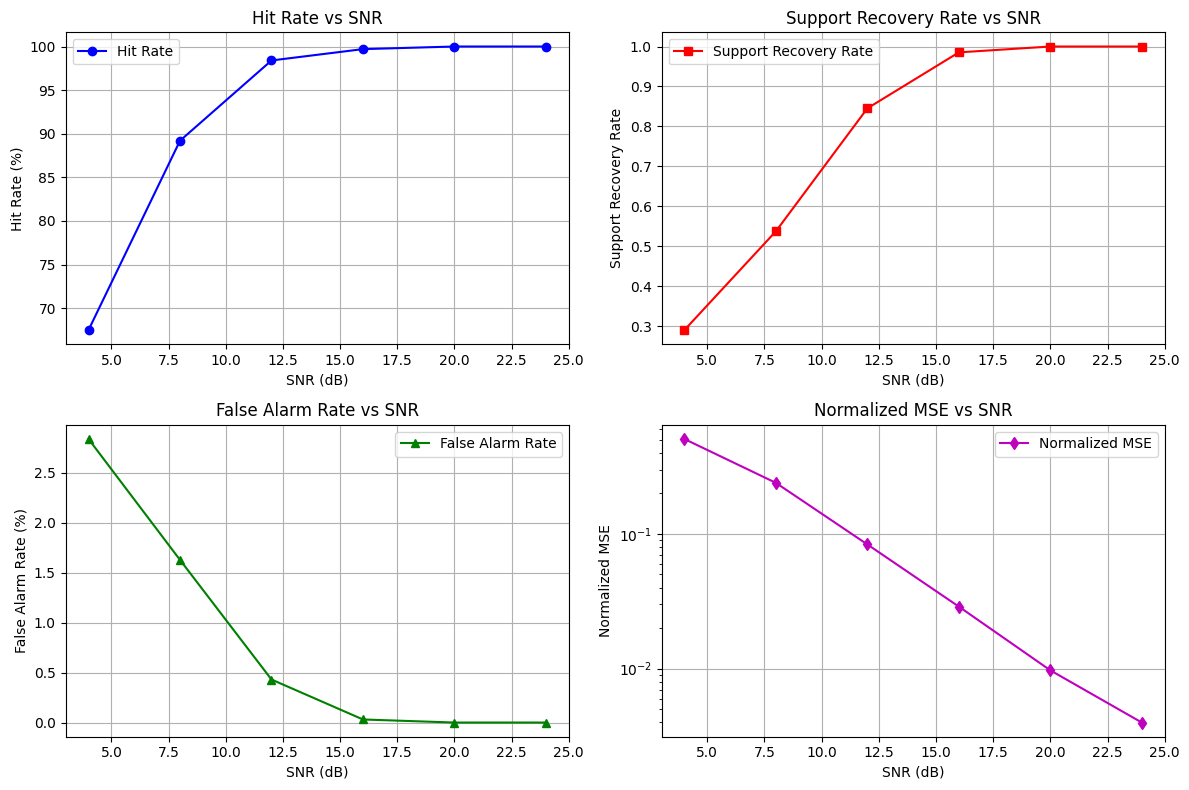

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(snr_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate
plt.subplot(2, 2, 2)
plt.plot(snr_values, avg_support_recovery_rate_sbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(snr_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(snr_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sbl_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

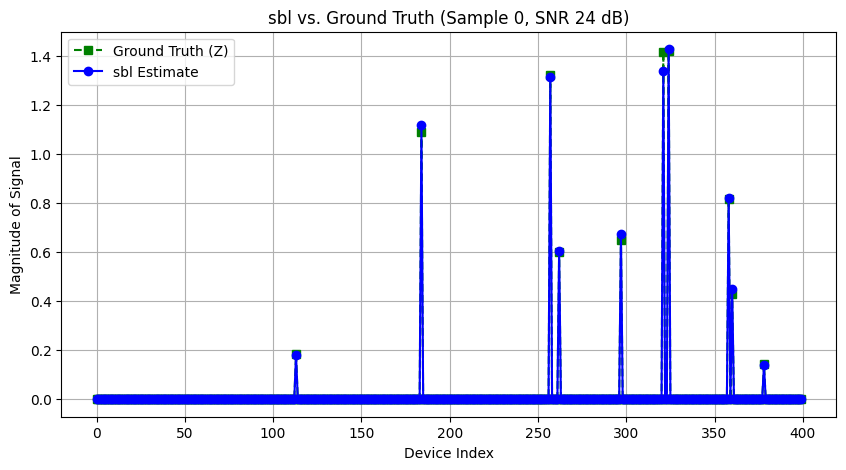

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_sbl_vs_ground_truth(z_sbl, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_sbl_vs_ground_truth(gamma_sbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_sbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


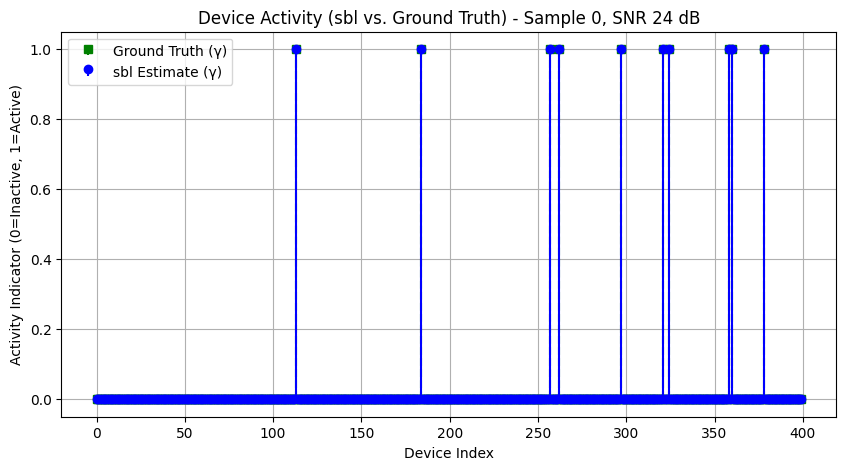

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_sbl_vs_ground_truth(gamma_sbl, all_gamma, sample_index, snr_index, snr_value)